## 0.PRE

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import cv2

### mount google drive

In [ ]:
DRIVE_HOME='/content/drive/My Drive/python/sound/'
DATA_LOC = 'data/blues.00000.wav'

In [65]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Load 

### load sound files

In [66]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, _, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, np.log(spec.T.astype(np.float32) + eps)

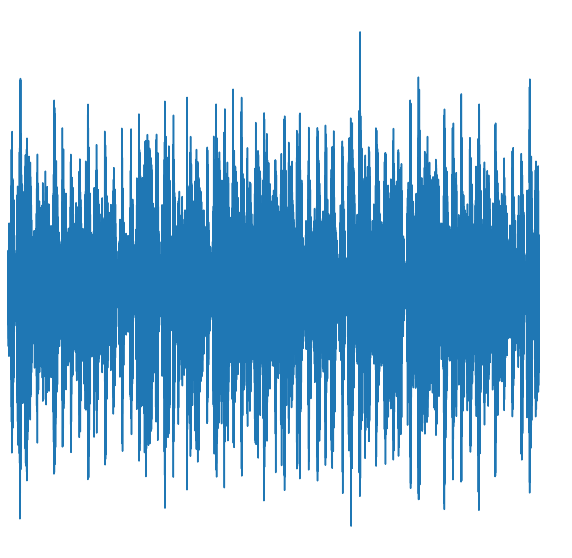

In [67]:
fig = plt.figure(figsize=(10,10))

plt.subplot()


# create spectogram
## read wave
samplerate, test_sound  = wavfile.read(DRIVE_HOME+DATA_LOC)
_, spectrogram = log_specgram(test_sound, samplerate)

plt.imshow(spectrogram.T, aspect='auto', origin='lower')

plt.plot(test_sound)

plt.axis('off')
plt.gray()

### file info

In [68]:
print(test_sound[:5])
print(len(test_sound))
print(len(test_sound)/30)
print(len(test_sound)/30/22000)

from math import sqrt, pow


## dimentionss
DIMEN_N = int(round(sqrt(len(test_sound)),0)-1) ; DIMEN_N_2 = DIMEN_N**2
print(DIMEN_N, ', pow :', DIMEN_N_2)
print('max : ', max(test_sound), ', min : ', min(test_sound))


[ 240  544  250 -115  -74]
661794
22059.8
1.0027181818181818
813 , pow : 660969
max :  29012 , min :  -27533


### reshape np array

In [69]:
## reshape
print(len(test_sound[0:DIMEN_N_2]))
test_sound_2d = test_sound[:DIMEN_N_2].reshape(-1,DIMEN_N)
test_sound_2d.shape

660969


(813, 813)

### normalization

In [ ]:
## normalization 

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

test_sound_2d_norm = scaler.fit_transform(test_sound_2d) * 255
test_sound_2d_norm = test_sound_2d_norm.astype(int)
test_sound_2d_norm


## D.N.S

In [71]:
from skimage import feature

In [91]:
24*24 ## feature matrix shape

576

### define functions

In [98]:
# define parameters ::: window size
SEARCH_SIZE = 21
NEIGHBOR_SIZE = 13

In [92]:
def get_pages(nd_array=test_sound_2d_norm, search_size=SEARCH_SIZE, neighbor_size=NEIGHBOR_SIZE) : 
    '''
    전체 matrix를 계산할 sub-matrix 로 분할하여 그 리스트를 return 하는 함수
    '''
    ND_LIST = []
    ## calcluate n*n 의 갯수
    size_x, size_y = test_sound_2d.shape
    div_ = SEARCH_SIZE + NEIGHBOR_SIZE - 1
    ind_x, ind_y = size_x // div_, size_y // div_
    cent_p = (div_ -1, div_ -1)

    ## slicing
    for i in range(ind_x) : 
        for j in range(ind_y) : 
            ND_LIST.append(test_sound_2d_norm[i*div_:(i+1)*div_,j*div_:(j+1)*div_])
    
    #print(len(ND_LIST))
    return ND_LIST    

%time ND_LIST = get_pages()

In [94]:
def ed_dist(nd_1, nd_2, round_arg = 1) :
    '''
    2개의 matrix의 ED distance를 return 하는 함수
    round_arg : 소숫점 자리수. default : 1
    '''
    squarer = lambda t: pow(t,2) 
    vfunc = np.vectorize(squarer)

    temp_nd = (nd_1 - nd_2).reshape(-1) ** 2
    return round(math.sqrt(sum(temp_nd)),1)

%time ed_dist(ND_LIST[0][0:3,0:3] , ND_LIST[0][4:7,4:7]) ## test

CPU times: user 167 µs, sys: 0 ns, total: 167 µs
Wall time: 172 µs


40.6

In [95]:

def cal_dns_mat(nd_array=ND_LIST, search_size=SEARCH_SIZE, neighbor_size=NEIGHBOR_SIZE) :
    '''
    matrix array에 대한 dns 계산하여 np array (SEARCH_SIZE X SEARCH_SIZE X len(ND_LIST)) 를 return
    '''

    ### cent of matrix position 
    CENT_P = (search_size//2 + neighbor_size//2 + 1, search_size//2 + neighbor_size//2 + 1)
    
    ### result array
    result_mat = np.array(np.zeros((SEARCH_SIZE,SEARCH_SIZE,len(ND_LIST))))
    #print(nd_array[0][CENT_P[0]-(neighbor_size//2):CENT_P[0]+(neighbor_size//2)+1,CENT_P[1]-(neighbor_size//2):CENT_P[1]+(neighbor_size//2)+1].shape)
    
    ## for phase
    for ind_mat, mat_x in enumerate(nd_array) : ## number of nd_array
        single_mat = np.zeros((SEARCH_SIZE,SEARCH_SIZE))
        #print('----init....\n',single_mat, '\n\n')
        for x in range(SEARCH_SIZE) : ## size of x-axis
            for y in range(SEARCH_SIZE) : ## size of y-axis
                ## calculate ED distance
                ## update result of matrix
                single_mat[x,y] = ed_dist(mat_x[x:x+neighbor_size,y:y+neighbor_size],
                                          mat_x[CENT_P[0]-(neighbor_size//2):CENT_P[0]+(neighbor_size//2)+1,CENT_P[1]-(neighbor_size//2):CENT_P[1]+(neighbor_size//2)+1])
        #print('----after update....\n',single_mat, '\n\n')
        ## update center of matrix as np.zeros
        #single_mat[CENT_P,CENT_P] = 0 
        
        #print('----finally....\n',single_mat, '\n\n')
        ## put matrix to final result matrix
        result_mat[:,:,ind_mat] = single_mat
    ## get a mean value of each cell finally
    ##
    ##
    ## return result matrix
    return result_mat



### drive code

In [96]:
%time ND_LIST = get_pages()
%time result = cal_dns_mat(ND_LIST)
result.shape

CPU times: user 736 µs, sys: 0 ns, total: 736 µs
Wall time: 746 µs
CPU times: user 10.5 s, sys: 4.14 ms, total: 10.5 s
Wall time: 10.5 s


(21, 21, 576)

### plotting

(21, 21)


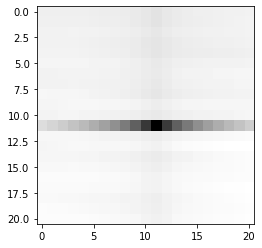

In [99]:
final_mat = result.mean(axis=2)
print(final_mat.shape)
plt.imshow(final_mat, cmap='gray')

## CNN ::: T.B.D

## (참고) STFT
    * STFT(Short-Time Fourier Transform)는 주파수 특성이 시간이 따라 달라지는 사운드를 분석하기 위한 방법이다. 
    * 시계열을 일정한 시간 구간으로 나누고 각 구간에 대해 스펙트럼을 구한 데이터이다. 
    * 시간-주파수의 2차원 데이터로 나타난다.

In [ ]:
print(np_sound)

NameError: ignored

In [ ]:
# iopub_data_rate_limit 설정을 10000000 정도로 크게 해야 한다.
D = np.abs(librosa.stft(np_sound))
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max, ), y_axis='linear', x_axis='time')
plt.title('Dual Tone')
plt.ylim(0, 4000)
plt.show()

NameError: ignored

In [ ]:
librosa.display.specshow(librosa.amplitude_to_db(test_sound_2d_norm, ref=np.max), y_axis='linear', x_axis='time')
plt.ylim(0, 260)
plt.gray()
plt.show()

In [ ]:
print(test_sound_2d_norm.shape)
print(test_sound_2d_norm.min(), test_sound_2d_norm.max())